In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [156]:

# plotly is an advanced visualization tool
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [157]:
import warnings
warnings.filterwarnings("ignore")

In [158]:
from STOCKERQ import Stocker

In [159]:
pd.set_option('display.max_rows', 10)

In [160]:
apple = Stocker("AAPL")

[*********************100%***********************]  1 of 1 completed
AAPL Stocker Initialized. Data covers 1980-12-12 00:00:00 to 2020-04-07 00:00:00.


In [161]:
df = apple.stock

In [162]:
df = df.reset_index()

In [227]:
df = df[['index','Date', 'Open', 'High', 'Low', 'Close','Volume']]

In [228]:
df['change%'] = (df['Open']/ df['Open'].shift(1)-1)*100

In [229]:
df = df[df['Date'] >= '2010-01-01']

In [230]:
df

,index,Date,Open,High,Low,Close,Volume,change%
7330,7330,2010-01-04,30.490000,30.642857,30.340000,30.572857,123432400,NaN
7331,7331,2010-01-05,30.657143,30.798571,30.464285,30.625713,150476200,0.548189
7332,7332,2010-01-06,30.625713,30.747143,30.107143,30.138571,138040000,-0.102519
7333,7333,2010-01-07,30.250000,30.285715,29.864286,30.082857,119282800,-1.226791
7334,7334,2010-01-08,30.042856,30.285715,29.865715,30.282858,111902700,-0.684773
...,...,...,...,...,...,...,...,...
9908,9908,2020-04-01,246.500000,248.720001,239.130005,240.910004,44054600,-3.560253
9909,9909,2020-04-02,240.339996,245.149994,236.899994,244.929993,41483500,-2.498987
9910,9910,2020-04-03,242.800003,245.699997,238.970001,241.410004,32470000,1.023553
9911,9911,2020-04-06,250.899994,263.109985,249.380005,262.470001,50289700,3.336075


In [231]:
df['log_price'] = np.log(df['Open'])

In [232]:
df['change%'] = (df['Open']/ df['Open'].shift(1)-1)*100

In [233]:
df['pct_change'] = df['log_price'].diff()

In [234]:
df['stdev'] = df['pct_change'].rolling(window=30, center=False).std()
df['Volatility'] = df['stdev'] * (252**0.5) # Annualize.

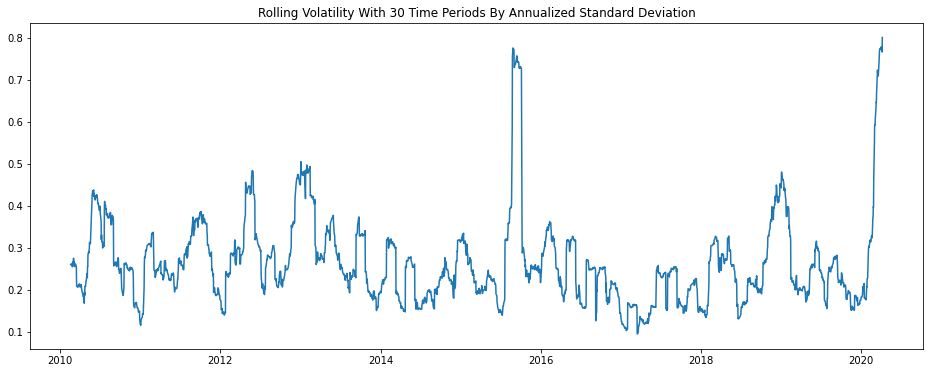

In [235]:
plt.figure(figsize=(16,6))
plt.title("Rolling Volatility With 30 Time Periods By Annualized Standard Deviation")
plt.plot(df['Date'], df['Volatility'], linestyle='solid')

In [236]:
df = df.dropna()

In [237]:
vol = df["Volatility"] * 100

In [238]:
from arch import arch_model
am = arch_model(vol, vol='Garch', p=1, o=0, q=1, dist='Normal')

In [239]:
res = am.fit(disp='off')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             Volatility   R-squared:                      -0.055
Mean Model:             Constant Mean   Adj. R-squared:                 -0.055
Vol Model:                      GARCH   Log-Likelihood:               -7738.14
Distribution:                  Normal   AIC:                           15484.3
Method:            Maximum Likelihood   BIC:                           15507.7
                                        No. Observations:                 2553
Date:                Wed, Apr 08 2020   Df Residuals:                     2549
Time:                        19:30:32   Df Model:                            4
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            23.8920      0.801     29.818 2.291e-195 [ 22.322, 25.462]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.7100      0.478      3.575  3.509e-04 [  0.772,  2.648]
alpha[1]       0.9626  9.664e-02      9.961  2.259e-23 [  0.773,  1.152]
beta[1]    3.7804e-15  9.495e-02  3.981e-14      1.000 [ -0.186,  0.186]
========================================================================

Covariance estimator: robust
"""

In [240]:
df['forecast_vol'] = 0.1 * np.sqrt(res.params['omega'] + res.params['alpha[1]'] * res.resid**2 + 
                                   res.conditional_volatility**2 * res.params['beta[1]'])

In [244]:
df = df.fillna(0)

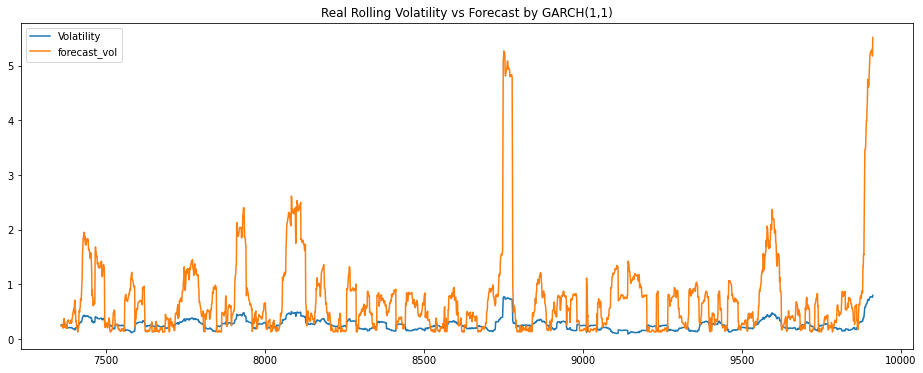

In [245]:
plt.figure(figsize=(16,6))
df["Volatility"].plot()
df["forecast_vol"].plot()
plt.title("Real Rolling Volatility vs Forecast by GARCH(1,1)")
plt.legend()
plt.show()

In [246]:
def rmse_tr(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
skor = rmse_tr(df.loc[df.index[1000:], 'forecast_vol'], df.loc[df.index[1000:], 'Volatility'])
print("Root Mean Squared Error of the model is calculated as ",skor)

Root Mean Squared Error of the model is calculated as  0.9292177849323945


In [247]:
df.shape

(2553, 13)

In [248]:
training_set = df.iloc[:, 11:12].values

In [178]:
def rmse_tr(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
skor = rmse_tr(df.loc[df.index[1000:], 'forecast_vol'], df.loc[df.index[1000:], 'Volatility'])
print("Root Mean Squared Error of the model is calculated as ",skor)

Root Mean Squared Error of the model is calculated as  0.9211900099766523


In [179]:
training_set = df.iloc[:, 11:12].values
# 100 timestep ve 1 çıktı ile data yapısı oluşturalım
X_train = []
y_train = []
for i in range(1000, df.shape[0]):
    X_train.append(training_set[i-1000:i,0])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [180]:
df.iloc[:, 11:12]


,Volatility
7330,NaN
7331,NaN
7332,NaN
7333,NaN
7334,NaN
...,...
9908,0.776984
9909,0.776723
9910,0.778821
9911,0.766252


In [181]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [182]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [108]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10))
regressor.add(Dropout(0.1))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1553/1553 [==============================] - 53s 34ms/step - loss: 0.0221
Epoch 2/100
1553/1553 [==============================] - 53s 34ms/step - loss: 0.0094
Epoch 3/100
1553/1553 [==============================] - 55s 35ms/step - loss: 0.0075
Epoch 4/100
1553/1553 [==============================] - 48s 31ms/step - loss: 0.0048
Epoch 5/100
1553/1553 [==============================] - 48s 31ms/step - loss: 0.0038
Epoch 6/100
1553/1553 [==============================] - 49s 32ms/step - loss: 0.0034
Epoch 7/100
1553/1553 [==============================] - 48s 31ms/step - loss: 0.0031
Epoch 8/100
1553/1553 [==============================] - 48s 31ms/step - loss: 0.0032
Epoch 9/100
1553/1553 [==============================] - 47s 30ms/step - loss: 0.0033
Epoch 10/100
1553/1553 [==============================] - 47s 30ms/step - loss: 0.0029
Epoch 11/100
1553/1553 [==============================] - 47s 30ms/step - loss: 0.0028
Epoch 12/100
1553/1553 [============================

In [109]:
regressor.save('my_modelp1.h5')

In [110]:
predicted_stock_price = regressor.predict(X_train)

In [153]:
from keras.models import load_model
regressor = load_model('my_modelp1.h5')

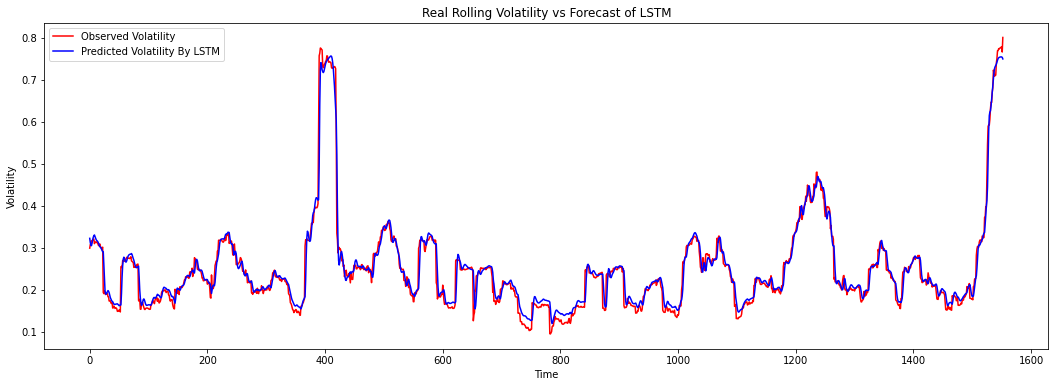

In [111]:
plt.figure(figsize=(18,6))
plt.plot(df.iloc[1000:, 11:12].values, color = 'red', label = 'Observed Volatility')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Volatility By LSTM')
plt.title('Real Rolling Volatility vs Forecast of LSTM')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [210]:
df

,index,Date,Open,High,Low,Close,Volume,change%,log_price,pct_change,stdev,Volatility,forecast_vol
7330,7330,2010-01-04,30.490000,30.642857,30.340000,30.572857,123432400,NaN,3.417399,NaN,NaN,NaN,NaN
7331,7331,2010-01-05,30.657143,30.798571,30.464285,30.625713,150476200,0.548189,3.422866,0.005467,NaN,NaN,NaN
7332,7332,2010-01-06,30.625713,30.747143,30.107143,30.138571,138040000,-0.102519,3.421840,-0.001026,NaN,NaN,NaN
7333,7333,2010-01-07,30.250000,30.285715,29.864286,30.082857,119282800,-1.226791,3.409496,-0.012344,NaN,NaN,NaN
7334,7334,2010-01-08,30.042856,30.285715,29.865715,30.282858,111902700,-0.684773,3.402625,-0.006871,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9908,9908,2020-04-01,246.500000,248.720001,239.130005,240.910004,44054600,-3.560253,5.507362,-0.036252,0.048945,0.776984,5.280756
9909,9909,2020-04-02,240.339996,245.149994,236.899994,244.929993,41483500,-2.498987,5.482055,-0.025307,0.048929,0.776723,5.278200
9910,9910,2020-04-03,242.800003,245.699997,238.970001,241.410004,32470000,1.023553,5.492238,0.010183,0.049061,0.778821,5.298776
9911,9911,2020-04-06,250.899994,263.109985,249.380005,262.470001,50289700,3.336075,5.525054,0.032816,0.048269,0.766252,5.175498


In [249]:
training_set = df.iloc[:, 11:13].values
# 100 timestep ve 1 çıktı ile data yapısı oluşturalım
X_train = []
y_train = []
for i in range(1000, df.shape[0]):
    X_train.append(training_set[i-1000:i,:])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [250]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))


In [252]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 2)))
regressor.add(Dropout(0.1))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10))
regressor.add(Dropout(0.1))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1553/1553 [==============================] - 54s 35ms/step - loss: 0.0175
Epoch 2/100
1553/1553 [==============================] - 53s 34ms/step - loss: 0.0092
Epoch 3/100
1553/1553 [==============================] - 46s 30ms/step - loss: 0.0072
Epoch 4/100
1553/1553 [==============================] - 45s 29ms/step - loss: 0.0065
Epoch 5/100
1553/1553 [==============================] - 46s 29ms/step - loss: 0.0052
Epoch 6/100
1553/1553 [==============================] - 46s 30ms/step - loss: 0.0042
Epoch 7/100
1553/1553 [==============================] - 50s 32ms/step - loss: 0.0040
Epoch 8/100
1553/1553 [==============================] - 50s 32ms/step - loss: 0.0040
Epoch 9/100
1553/1553 [==============================] - 49s 31ms/step - loss: 0.0035
Epoch 10/100
1553/1553 [==============================] - 50s 32ms/step - loss: 0.0036
Epoch 11/100
1553/1553 [==============================] - 49s 32ms/step - loss: 0.0036
Epoch 12/100
1553/1553 [============================

In [253]:
predicted_stock_price = regressor.predict(X_train)

In [221]:
predicted_stock_price

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

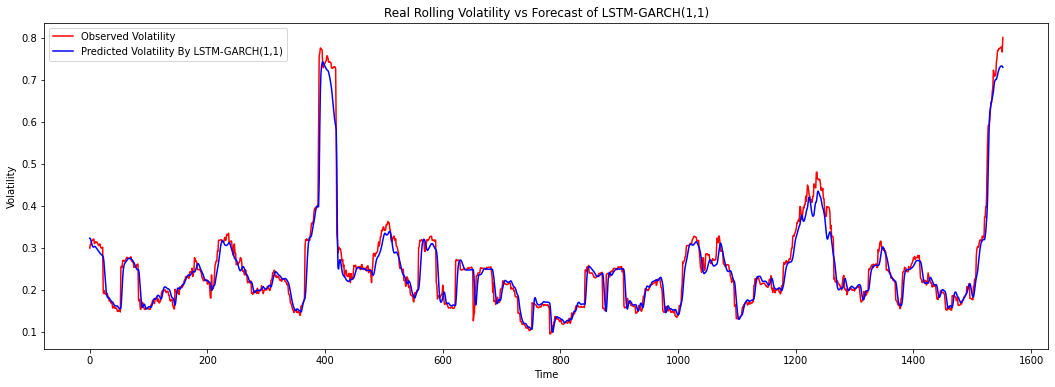

In [254]:
# Visualising the results
plt.figure(figsize=(18,6))
plt.plot(df.iloc[1000:, 11:12].values, color = 'red', label = 'Observed Volatility')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Volatility By LSTM-GARCH(1,1)')
plt.title('Real Rolling Volatility vs Forecast of LSTM-GARCH(1,1)')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [255]:
skor3 = rmse_tr(predicted_stock_price, np.array(df.loc[df.index[1000:], 'Volatility']))

In [257]:
print(skor3)

0.15508660091635929
